In [1]:
%load_ext autoreload
%autoreload 2

In [107]:
import os
from pathlib import Path

import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import time

import gym
from gym import error, spaces, utils
from gym.utils import seeding

import pinocchio as pin

from pinocchio.visualize import MeshcatVisualizer
import hppfcl
import example_robot_data as erd

from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import VecCheckNan , DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.utils import set_random_seed


import torch

In [207]:
class FrictionDPEnv(gym.Env):
    
    def __init__(self, friction, dt, T, target = np.array([0.0290872, 0., 0.135]),w_xterm = 1e-0, w_ureg = 1e-1, w_xcurr= 1e-7, w_xreg = 1e-7):
        super(FrictionDPEnv, self).__init__()
        #defining dynamical system
        robot = erd.load("double_pendulum")
        self.model = robot.model
        self.data = robot.data
        self.geom_model = robot.collision_model
        self.geom_data = robot.collision_data
        self.action_space = gym.spaces.Box(low=-10., high=10.,
                                        shape=(self.model.nv,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-1000., high=1000.,
                                        shape=(self.model.nq + self.model.nv,), dtype=np.float32)
        self.friction = friction
        self.init_state = np.zeros(self.model.nq + self.model.nv)
        self.init_state[0] += 1.*np.pi
        self.state = self.init_state
        self.instant = 0
        self.dt = dt
        self.T = T
        #defining cost weights
        self.target = target
        self.w_xterm = w_xterm
        self.w_ureg = w_ureg
        self.w_xcurr = w_xcurr
        self.w_xreg = w_xreg
        #define visualizer for rendering
        name = "pendulum"
        self.viz = MeshcatVisualizer(self.model, self.geom_model, self.geom_model)
        self.viz.initViewer()
        self.viz.loadViewerModel(name)
        self.viz.display(self.state[:self.model.nq])
        return 

    def step(self, action):
        #print("action", action)
        q,v = self.RK4Update_with_friction(action)
        pin.forwardKinematics(self.model, self.data, q, v)
        pin.updateFramePlacements(self.model, self.data)
        self.state = np.concatenate((q,v), axis= 0)
        self.instant += 1
        if self.instant == self.T:
            done = True
        else:
            done = False
        reward = self.compute_reward(self.state, action)
        info = {}
        #print("state",self.state)
        return self.state, reward, done, info

    def reset(self):
        self.instant = 0 
        self.state = self.init_state
        return self.state

    def render(self):
        self.viz.display(self.state[:self.model.nq])
        return
    
    def compute_reward(self, state, action):
        reward = - self.w_ureg*.5*(np.linalg.norm(action)**2)
        #print("reward1", - self.w_ureg*.5*(np.linalg.norm(action)**2))
        reward += - self.w_xreg*.5*(np.linalg.norm(state)**2)
        #print("reward2", - self.w_xreg*.5*(np.linalg.norm(action)**2))
        if self.instant == self.T:
            reward += - self.w_xterm*.5*(np.linalg.norm(self.data.oMi[2].translation - self.target)**2)
            #print("reward3 terminal", - self.w_xterm*.5*(np.linalg.norm(self.data.oMi[2].translation - self.target)**2))
        else:
            reward += - self.w_xcurr*.5*(np.linalg.norm(self.data.oMi[2].translation - self.target)**2)
            #print("reward3", - self.w_xcurr*.5*(np.linalg.norm(self.data.oMi[2].translation - self.target)**2))
        return reward
    
    def aba_with_friction(self,model,data,q,v,u,cf):
        a = pin.aba(model,data,q,v,u)
        Minv = np.linalg.inv(pin.crba(model,data,q))
        af = np.where(np.abs(v) < 1e-3, 
                      np.sign(a)*np.clip(np.abs(a)-np.abs(np.dot(Minv,np.sign(a)*cf)),0,None),
                      a-np.dot(Minv,np.sign(v)*cf))
        return af
    
    def RK4Update_with_friction(self,u):
        cf = self.friction*np.ones(u.shape)
        q,v = self.state[:self.model.nq], self.state[-self.model.nv:]
        a1 = self.aba_with_friction(self.model,self.data,q,v,u,cf)
        q1,v1 = pin.integrate(self.model, q,v*self.dt/2), v+a1*self.dt/2
        a2 = self.aba_with_friction(self.model,self.data,q1,v1,u,cf)
        q2,v2 = pin.integrate(self.model, q,v1*self.dt/2), v+a2*self.dt/2
        a3 = self.aba_with_friction(self.model,self.data,q2,v2,u,cf)
        q3,v3 = pin.integrate(self.model, q,v2*self.dt), v+a3*self.dt
        a4 = self.aba_with_friction(self.model,self.data,q3,v3,u,cf)
        return pin.integrate(self.model, q,(self.dt/3)*((1/2)*v+v1+v2+(1/2)*v3)), v+ (self.dt/3)*((1/2)*a1 + a2 + a3 + (1/2)*a4)

    
    def close(self):
        return

In [208]:
def make_env( friction, dt, T, seed=0):
    def _init():
        env = FrictionDPEnv(friction, dt, T)
        return env
    set_random_seed(seed)
    return _init

In [209]:
friction = 0.01
T = 1500
dt = 0.001
env = FrictionDPEnv(friction, dt, T)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7212/static/


In [210]:
check_env(env)

# PPO

In [193]:
nb_envs = 4
env = SubprocVecEnv([make_env(friction, dt, T, i) for i in range(nb_envs)])

In [194]:
path_curr = Path().cwd()
os.makedirs(path_curr/'logs'/'double_pendulum'/'PPO', exist_ok=True)

eval_env = SubprocVecEnv([make_env(friction, dt, T, i) for i in range(nb_envs)])
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/double_pendulum/PPO/',
                             log_path='./logs/double_pendulum/PPO', n_eval_episodes=1, eval_freq=T*2,
                             deterministic=True)

policy_kwargs = dict(net_arch=[64, 64], log_std_init = .1)

model = PPO("MlpPolicy", env, learning_rate = 1e-4, verbose=0, policy_kwargs = policy_kwargs)

In [187]:
model.learn(total_timesteps=T*300, callback= eval_callback)

Eval num_timesteps=12000, episode_reward=-0.20 +/- 0.00
Episode length: 1500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=24000, episode_reward=-0.70 +/- 0.00
Episode length: 1500.00 +/- 0.00


KeyboardInterrupt: 

# SAC

In [153]:
path_curr = Path().cwd()
os.makedirs(path_curr/'logs'/'double_pendulum'/'SAC', exist_ok=True)

env = DummyVecEnv([lambda:FrictionDPEnv(friction, dt, T)])
eval_env = DummyVecEnv([lambda: FrictionDPEnv(friction, dt, T)])
#eval_env = FrictionDPEnv(friction, dt, T)

eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/double_pendulum/SAC/',
                             log_path='./logs/double_pendulum/SAC/', eval_freq=T*5,
                             deterministic=True)

policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))

action_noise = NormalActionNoise(0.,.1)#np.zeros((env.model.nv,), dtype= np.float32), 1.)
model = SAC("MlpPolicy", env, verbose=0, action_noise = action_noise)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7170/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7171/static/


In [154]:
model.learn(total_timesteps=T*100, callback= eval_callback)

Eval num_timesteps=7500, episode_reward=-6.11 +/- 0.00
Episode length: 1500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=15000, episode_reward=-29.20 +/- 0.00
Episode length: 1500.00 +/- 0.00
Eval num_timesteps=22500, episode_reward=-10.67 +/- 0.00
Episode length: 1500.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=-12.34 +/- 0.00
Episode length: 1500.00 +/- 0.00
Eval num_timesteps=37500, episode_reward=-16.30 +/- 0.00
Episode length: 1500.00 +/- 0.00
Eval num_timesteps=45000, episode_reward=-19.72 +/- 0.00
Episode length: 1500.00 +/- 0.00


KeyboardInterrupt: 

# A2C

In [106]:
path_curr = Path().cwd()
os.makedirs(path_curr/'logs'/'double_pendulum'/'A2C', exist_ok=True)

eval_env = FrictionDPEnv(friction, dt, T)
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/double_pendulum/A2C/',
                             log_path='./logs/double_pendulum/A2C/', eval_freq=T*5,
                             deterministic=True)

policy_kwargs = dict(net_arch=dict(pi=[16, 16], qf=[16, 16]))

#action_noise = NormalActionNoise(np.zeros((env.model.nv,), dtype= np.float32), np.ones(env.model.nv, dtype = np.float32))
model = A2C("MlpPolicy", env, verbose=0)#, action_noise = action_noise)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7064/static/


In [107]:
model.learn(total_timesteps=T*200, callback = eval_callback)

Eval num_timesteps=7500, episode_reward=-10.14 +/- 0.00
Episode length: 1500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=15000, episode_reward=-1.28 +/- 0.00
Episode length: 1500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=22500, episode_reward=-0.88 +/- 0.00
Episode length: 1500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=-0.77 +/- 0.00
Episode length: 1500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=37500, episode_reward=-0.65 +/- 0.00
Episode length: 1500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=45000, episode_reward=-1.46 +/- 0.00
Episode length: 1500.00 +/- 0.00
Eval num_timesteps=52500, episode_reward=-0.89 +/- 0.00
Episode length: 1500.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=-0.60 +/- 0.00
Episode length: 1500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=67500, episode_reward=-1.05 +/- 0.00
Episode length: 1500.00 +/- 0.00
Eval num_timesteps=75000, episode_reward=-0.73 +/- 0.00
Episode len

KeyboardInterrupt: 

# Plotting and rendering results 

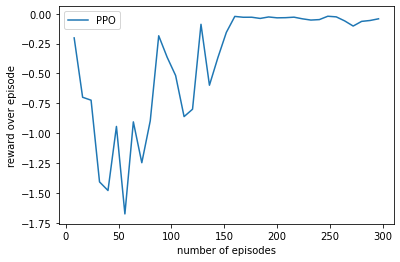

In [155]:
res_trainPPO =  np.load("logs/double_pendulum/PPO/evaluations.npz")
res_trainSAC =  np.load("logs/double_pendulum/SAC/evaluations.npz")
res_trainA2C =  np.load("logs/double_pendulum/A2C/evaluations.npz")

plt.figure()
plt.plot(res_trainPPO["timesteps"]/1500., res_trainPPO["results"][:,0], label = "PPO")
plt.xlabel("number of episodes")
plt.ylabel("reward over episode")
plt.legend()
plt.show()

In [211]:
env = FrictionDPEnv(friction, dt, T)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7213/static/


In [212]:
model = PPO.load("logs/double_pendulum/PPO/best_model")

In [213]:
obs = env.reset()
states =[]
actions = []
rewards = []
for i in range(T):
    action, _states = model.predict(obs)
    actions += [action]
    obs, reward, dones, info = env.step(action)
    states += [obs]
    rewards += [reward]

In [214]:
env.viz.viewer.jupyter_cell()

In [215]:
env.viz.display(states[0][:env.model.nv])
time.sleep(1.)
env.viz.play(np.array(states)[:,:env.model.nv].T, dt=dt)

In [216]:
print(rewards,sum(rewards))

[-0.02808226511719381, -0.009071009285979793, -0.18185342496972265, -0.02045579012608721, -0.10000820780313861, -0.04660113038240659, -0.014709733497995465, -0.01185299515238109, -0.023148856324565193, -0.07777930923679569, -0.06479054348189867, -0.15580849734546565, -0.2681914653445813, -0.06158307516430626, -0.10476395321741837, -0.030245945504912018, -0.0018165810150378135, -0.05931901212976369, -0.008364593415840631, -0.08160605041802864, -0.031061103414313507, -0.04358253106932482, -0.06641548142756531, -0.16295705390951906, -0.34083727587633306, -0.2319581069225228, -0.2972172527561355, -0.25851506434771326, -0.021367586804094167, -0.14351446074265733, -0.1230846035466633, -0.0629327737258961, -0.10346928347862903, -0.008582941121579632, -0.1776537203917642, -4.205913617899616e-05, -0.09816472239260554, -0.07252566169951186, -0.19196400138870212, -0.31868136846926015, -0.09256558835045849, -0.0007845577932294254, -0.0905040726556276, -0.026118044945269567, -0.15889348596394237, -